In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

## 1. Import data

In [2]:
#A high level overview of the first 20 lines of the data
dataset= pd.read_csv('kc_house_data.csv')
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
dataset.shape

(21613, 21)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## 2. Data preprocessing 

In [5]:
#Check if there is duplication using unique id
len(dataset.id.unique())

21436

In [6]:
#check total duplicated records using id
dataset.duplicated('id').sum()

177

In [7]:
#drop the duplications
dataset = dataset.drop_duplicates(subset='id')

In [8]:
#Check data shape
dataset.shape

(21436, 21)

In [9]:
#convert type for the attribute "date" and then create three more columns out of this column
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['year'] = dataset['date'].dt.year
dataset['month'] = dataset['date'].dt.month
dataset['day'] = dataset['date'].dt.day
dataset = dataset.drop("date",axis=1)

In [10]:
data = dataset['year']- dataset['yr_built']
print (data)

0        59
1        63
2        82
3        49
4        28
         ..
21608     5
21609     1
21610     5
21611    11
21612     6
Length: 21436, dtype: int64


In [11]:
# Add a new column 
dataset['Age of the house'] = data
dataset.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,Age of the house
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,0,98178,47.5112,-122.257,1340,5650,2014,10,13,59
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,1991,98125,47.7210,-122.319,1690,7639,2014,12,9,63
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,0,98028,47.7379,-122.233,2720,8062,2015,2,25,82
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,0,98136,47.5208,-122.393,1360,5000,2014,12,9,49
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,0,98074,47.6168,-122.045,1800,7503,2015,2,18,28


In [12]:
#rename the columns
dataset.rename(columns = { 
              'sqft_living' : 'Living Space',
              'sqft_lot' : 'Landsize',
              'view' : 'View rating',
              'sqft_above' : 'Living Space Above Ground',
              'sqft_basement' : 'Basement',
                        
                        },inplace = True)

In [13]:
## Drop ID
dataset = dataset.drop(["id"],axis=1)
dataset.head()

,price,bedrooms,bathrooms,Living Space,Landsize,floors,waterfront,View rating,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,Age of the house
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,1340,5650,2014,10,13,59
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1991,98125,47.7210,-122.319,1690,7639,2014,12,9,63
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,98028,47.7379,-122.233,2720,8062,2015,2,25,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,0,98136,47.5208,-122.393,1360,5000,2014,12,9,49
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,1800,7503,2015,2,18,28


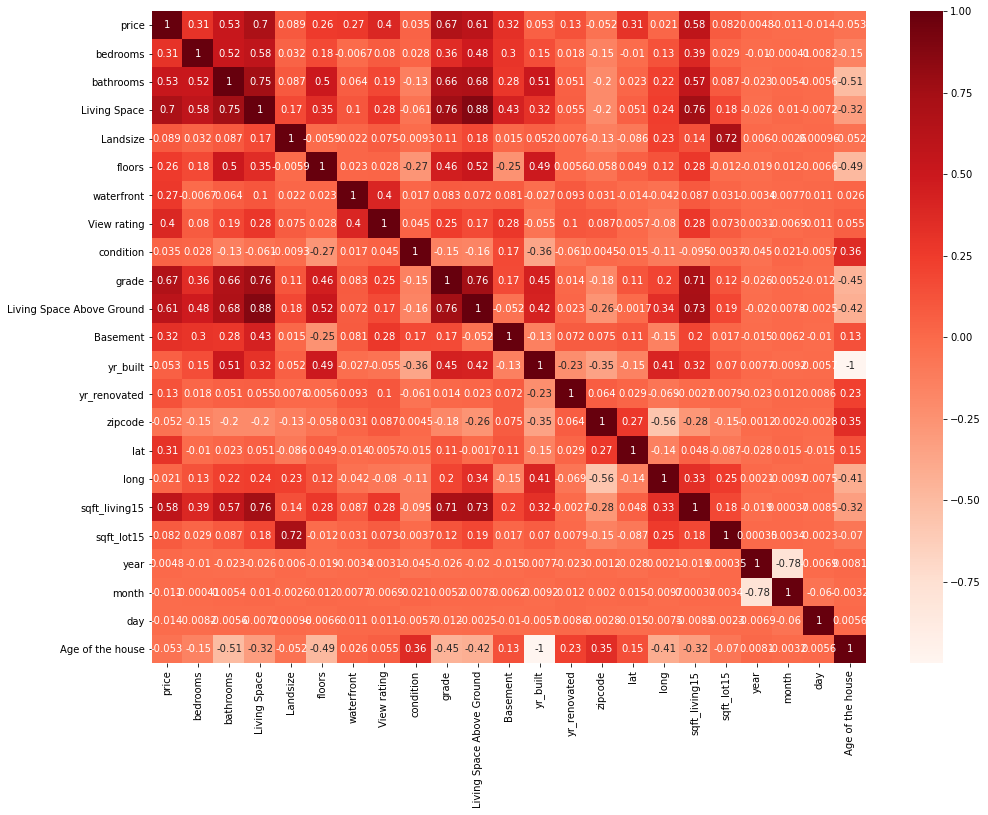

In [14]:
cor = dataset.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [15]:
dataset.corr()["price"].sort_values(ascending=False)

price                        1.000000
Living Space                 0.701993
grade                        0.667496
Living Space Above Ground    0.605495
sqft_living15                0.584688
bathrooms                    0.525453
View rating                  0.396933
Basement                     0.323552
bedrooms                     0.309007
lat                          0.306057
waterfront                   0.266961
floors                       0.256278
yr_renovated                 0.127002
Landsize                     0.088895
sqft_lot15                   0.082038
yr_built                     0.052967
condition                    0.035089
long                         0.020571
year                         0.004800
month                       -0.010684
day                         -0.014374
zipcode                     -0.052171
Age of the house            -0.052891
Name: price, dtype: float64

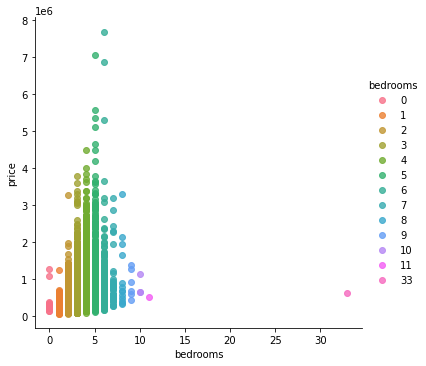

In [16]:
#Scatter plot for .
sns.lmplot(x='bedrooms', y='price', data=dataset,
           fit_reg=False, # No regression line
           hue='bedrooms')   # Color by evolution stage

In [17]:
#Check other attributes informations 
outliercheck = dataset.sort_values('bedrooms')
outliercheck

,price,bedrooms,bathrooms,Living Space,Landsize,floors,waterfront,View rating,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,Age of the house
3119,380000.0,0,0.00,1470,979,3.0,0,2,3,8,...,0,98133,47.7145,-122.356,1470,1399,2015,2,5,9
8484,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,...,0,98038,47.3493,-122.053,1810,5685,2014,9,25,11
3467,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,...,0,98125,47.7222,-122.290,1430,1650,2014,8,5,15
4868,228000.0,0,1.00,390,5900,1.0,0,0,2,4,...,0,98118,47.5260,-122.261,2170,6000,2014,10,2,61
18379,265000.0,0,0.75,384,213444,1.0,0,0,3,4,...,0,98070,47.4177,-122.491,1920,224341,2014,10,29,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15161,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,...,0,98006,47.5705,-122.175,2040,11914,2014,10,29,56
13314,1148000.0,10,5.25,4590,10920,1.0,0,2,3,9,...,0,98004,47.5861,-122.113,2730,10400,2014,8,14,6
19254,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,...,0,98105,47.6635,-122.320,1810,3745,2014,12,29,101
8757,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,...,1999,98106,47.5560,-122.363,1420,4960,2014,8,21,96


In [18]:
#Checking the details of record 15870
dataset.loc[15870]

price                        640000.0000
bedrooms                         33.0000
bathrooms                         1.7500
Living Space                   1620.0000
Landsize                       6000.0000
floors                            1.0000
waterfront                        0.0000
View rating                       0.0000
condition                         5.0000
grade                             7.0000
Living Space Above Ground      1040.0000
Basement                        580.0000
yr_built                       1947.0000
yr_renovated                      0.0000
zipcode                       98103.0000
lat                              47.6878
long                           -122.3310
sqft_living15                  1330.0000
sqft_lot15                     4700.0000
year                           2014.0000
month                             6.0000
day                              25.0000
Age of the house                 67.0000
Name: 15870, dtype: float64

In [19]:
#Replace bedroom for record 15670 with 3
dataset.loc[dataset.bedrooms == 33, 'bedrooms'] = 3
dataset.loc[15870]

price                        640000.0000
bedrooms                          3.0000
bathrooms                         1.7500
Living Space                   1620.0000
Landsize                       6000.0000
floors                            1.0000
waterfront                        0.0000
View rating                       0.0000
condition                         5.0000
grade                             7.0000
Living Space Above Ground      1040.0000
Basement                        580.0000
yr_built                       1947.0000
yr_renovated                      0.0000
zipcode                       98103.0000
lat                              47.6878
long                           -122.3310
sqft_living15                  1330.0000
sqft_lot15                     4700.0000
year                           2014.0000
month                             6.0000
day                              25.0000
Age of the house                 67.0000
Name: 15870, dtype: float64

In [20]:
outliercheck1 = dataset.sort_values('bathrooms')
outliercheck1

,price,bedrooms,bathrooms,Living Space,Landsize,floors,waterfront,View rating,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,Age of the house
10481,484000.0,1,0.00,690,23244,1.0,0,0,4,7,...,0,98053,47.6429,-121.955,1690,19290,2014,9,18,66
3119,380000.0,0,0.00,1470,979,3.0,0,2,3,8,...,0,98133,47.7145,-122.356,1470,1399,2015,2,5,9
6994,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,...,0,98053,47.6642,-122.069,4740,35061,2014,6,24,24
19452,142000.0,0,0.00,290,20875,1.0,0,0,1,1,...,0,98024,47.5308,-121.888,1620,22850,2014,9,26,51
14423,139950.0,0,0.00,844,4269,1.0,0,0,4,7,...,0,98001,47.2781,-122.250,1380,9600,2015,4,13,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8092,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,...,2009,98040,47.5570,-122.210,3270,10454,2014,6,17,31
8546,450000.0,9,7.50,4050,6504,2.0,0,0,3,7,...,0,98144,47.5923,-122.301,1448,3866,2014,8,11,18
9254,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,...,0,98039,47.6305,-122.240,4540,42730,2014,9,19,13
12777,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,...,0,98053,47.6675,-121.986,4850,217800,2014,5,5,15


In [21]:
#Locate the sales records with 0 rooms
outliercheck1.head(40)

,price,bedrooms,bathrooms,Living Space,Landsize,floors,waterfront,View rating,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,Age of the house
10481,484000.0,1,0.00,690,23244,1.0,0,0,4,7,...,0,98053,47.6429,-121.955,1690,19290,2014,9,18,66
3119,380000.0,0,0.00,1470,979,3.0,0,2,3,8,...,0,98133,47.7145,-122.356,1470,1399,2015,2,5,9
6994,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,...,0,98053,47.6642,-122.069,4740,35061,2014,6,24,24
19452,142000.0,0,0.00,290,20875,1.0,0,0,1,1,...,0,98024,47.5308,-121.888,1620,22850,2014,9,26,51
14423,139950.0,0,0.00,844,4269,1.0,0,0,4,7,...,0,98001,47.2781,-122.250,1380,9600,2015,4,13,102
5832,280000.0,1,0.00,600,24501,1.0,0,0,2,3,...,0,98045,47.5316,-121.749,990,22549,2014,11,4,64
9854,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,...,0,98065,47.5265,-121.828,1060,7200,2014,12,23,18
875,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,...,0,98102,47.6362,-122.322,2360,4000,2014,6,12,24
9773,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,...,0,98031,47.4095,-122.168,2520,8050,2015,4,29,25
1149,75000.0,1,0.00,670,43377,1.0,0,0,3,3,...,0,98022,47.2638,-121.906,1160,42882,2015,2,17,49


In [23]:
drop1 = dataset.drop([10481])
drop2 = drop1.drop([5832])
drop3 = drop2.drop([9773])
drop4 = drop3.drop([1149])
drop5 = drop4.drop([8477])
drop6 = drop5.drop([8484])
drop7 = drop6.drop([3467])
drop8 = drop7.drop([4868])
drop9 = drop8.drop([18379])
drop11= drop9.drop([12653])
drop12= drop11.drop([3119])
drop13= drop12.drop([6994])
drop14 = drop13.drop([19452])
drop15= drop14.drop([14423])
drop16= drop15.drop([9854])
final= drop16.drop([875])

## 3. EDA

In [24]:
def pieChartPlotter(dataset, columnName):
    """
    This function will take dataset and column as input and plot pie chart of the distribution within that column.
    """
    values = dataset[columnName].value_counts()
    labels = dataset[columnName].unique()
    pie, ax = plt.subplots(figsize=[10, 6])
    patches, texts, autotexts = ax.pie(
        values, labels=labels, autopct='%1.2f%%', 
        shadow=True, pctdistance=.5, 
        explode=[0.06]*dataset[columnName].unique()
    )
    plt.legend(patches, labels, loc="best")
    plt.title(columnName, color='white', fontsize=14)
    plt.setp(texts, color='white', fontsize=20)
    plt.setp(autotexts, size=10, color='white')
    autotexts[1].set_color('white')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

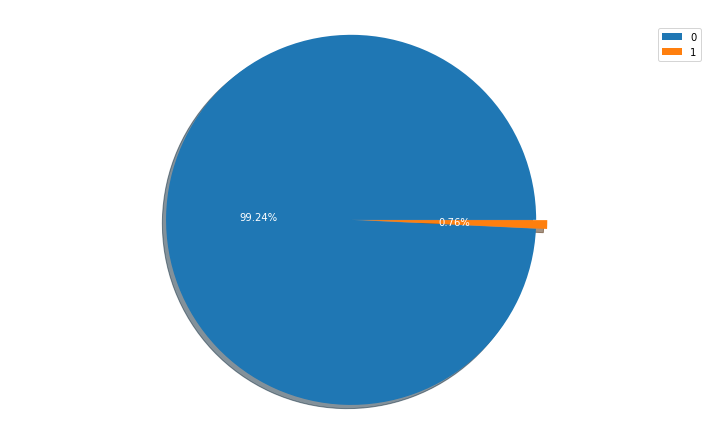

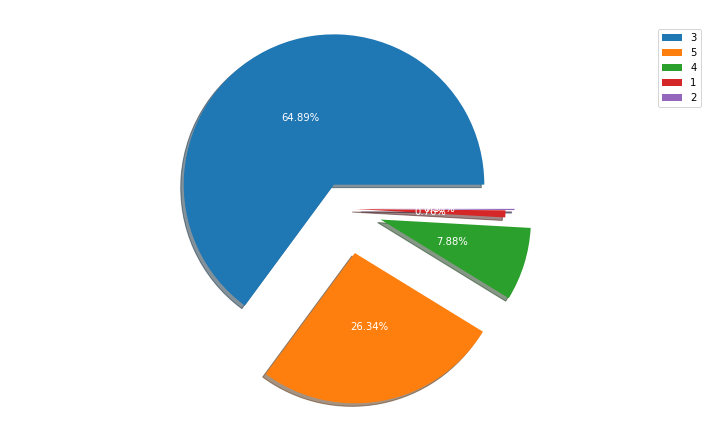

In [25]:
pieChartPlotter(final,'waterfront')
pieChartPlotter(final, 'condition')

In [26]:
#Find out the number of properties by zip code
print(Counter(final.zipcode))

Counter({98103: 600, 98038: 586, 98115: 576, 98052: 571, 98117: 548, 98042: 546, 98034: 543, 98118: 498, 98023: 492, 98006: 490, 98133: 484, 98059: 465, 98058: 451, 98155: 442, 98074: 435, 98033: 431, 98027: 411, 98056: 404, 98125: 402, 98053: 400, 98001: 358, 98075: 358, 98126: 352, 98092: 351, 98144: 340, 98106: 330, 98116: 329, 98029: 320, 98199: 316, 98004: 315, 98065: 305, 98122: 289, 98008: 283, 98028: 282, 98040: 282, 98146: 281, 98003: 276, 98198: 275, 98072: 272, 98031: 271, 98112: 268, 98107: 264, 98168: 264, 98136: 263, 98055: 260, 98178: 258, 98177: 254, 98030: 253, 98166: 250, 98022: 233, 98105: 229, 98045: 218, 98002: 197, 98077: 196, 98011: 194, 98019: 190, 98108: 185, 98119: 184, 98005: 168, 98007: 139, 98188: 135, 98032: 123, 98014: 123, 98070: 116, 98109: 109, 98102: 104, 98010: 99, 98024: 79, 98148: 56, 98039: 49})


In [27]:
# Top five locations with the highest sales record in the past year
data = [['Top1',98103,600],
        ['Top2',98038,587],
        ['Top3',98115,576], 
        ['Top4',98052,571], 
        ['Top5',98117,548]] 
top5= pd.DataFrame(data, columns = ['Ranking','Zipcode','Number of Sales']) 
top5 #print data frame 

,Ranking,Zipcode,Number of Sales
0,Top1,98103,600
1,Top2,98038,587
2,Top3,98115,576
3,Top4,98052,571
4,Top5,98117,548


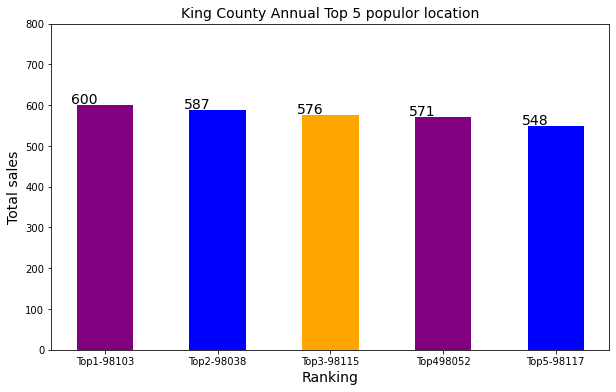

In [28]:
# Creating a graph to show the top 5 hot location
plt.figure(figsize=(10,6))
height = [600,587,576,571,548]
x_axis = ['Top1-98103','Top2-98038','Top3-98115','Top498052','Top5-98117']
plt.bar(x_axis, height, width =0.5, align='center', color=['Purple','Blue','Orange'])
plt.ylim(0, 800)#This sets the minimum and maximum value of Y-axis
figure = (600,587,576,571,548)
for index,data in enumerate(figure):
    plt.text( x = index-0.3, y=data+4, s=f'{data}', fontdict = dict(fontsize = 14))
plt.grid(False)  
plt.xlabel('Ranking', fontsize = 14)
plt.ylabel('Total sales', fontsize = 14)
plt.title('King County Annual Top 5 populor location', fontsize = 14)
plt.show()

In [29]:
top1 = dataset.loc[dataset['zipcode']  == 98103]

In [30]:
top1.head()

,price,bedrooms,bathrooms,Living Space,Landsize,floors,waterfront,View rating,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,Age of the house
17,485000.0,4,1.00,1600,4300,1.5,0,0,4,7,...,0,98103,47.6648,-122.343,1610,4300,2014,5,29,98
111,570000.0,3,1.75,1260,3328,1.0,0,0,5,6,...,0,98103,47.6823,-122.349,1380,3536,2015,3,4,110
116,518500.0,3,3.50,1590,1102,3.0,0,0,3,8,...,0,98103,47.6824,-122.347,1620,3166,2014,6,26,4
128,822500.0,5,3.50,2320,4960,2.0,0,0,5,7,...,0,98103,47.6763,-122.352,1700,4960,2014,6,13,88
149,511000.0,3,1.00,1430,3455,1.0,0,0,3,7,...,0,98103,47.6873,-122.336,1450,4599,2014,11,4,67


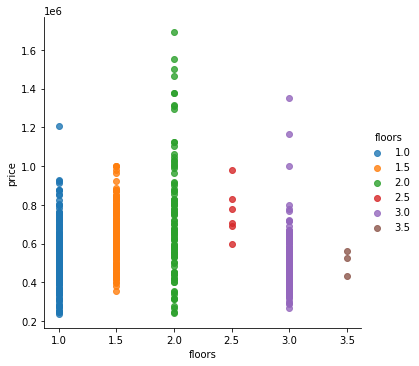

In [31]:
#Scatter plot for .
sns.lmplot(x='floors', y='price', data=top1,
           fit_reg=False, # No regression line
           hue='floors')   # Color by evolution stage

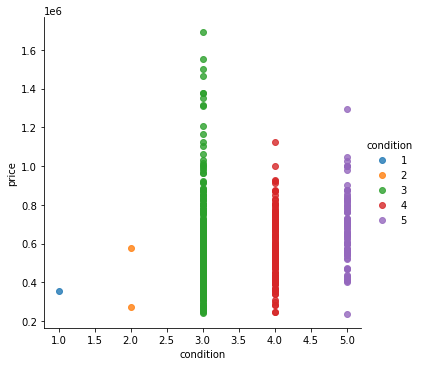

In [32]:
#Scatter plot for .
sns.lmplot(x='condition', y='price', data=top1,
           fit_reg=False, # No regression line
           hue='condition')   # Color by evolution stage

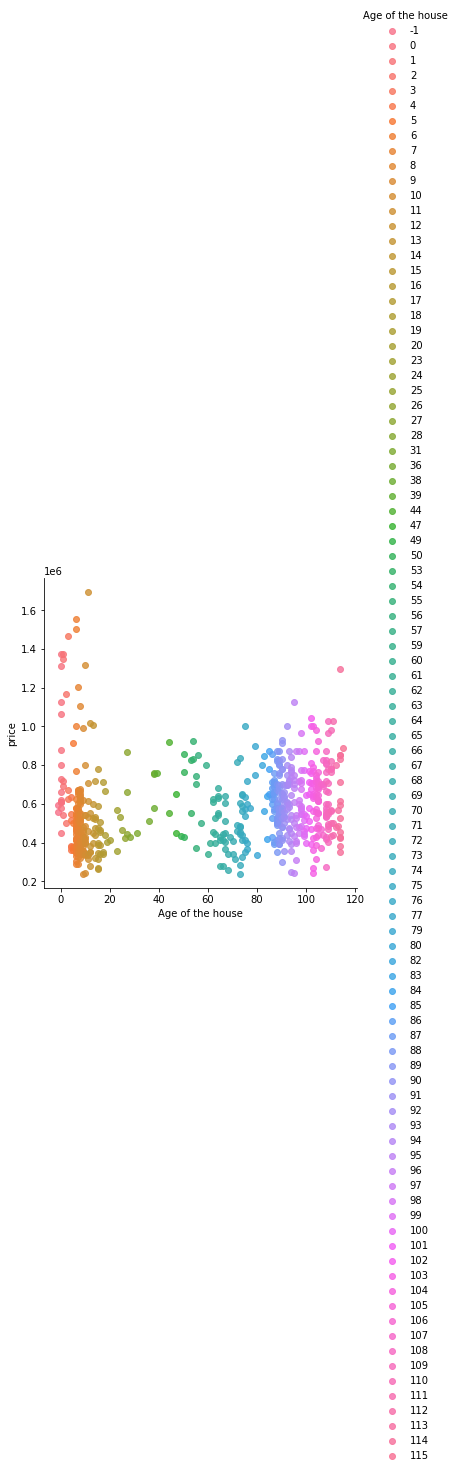

In [33]:
#Scatter plot for .
sns.lmplot(x='Age of the house', y='price', data=top1,
           fit_reg=False, # No regression line
           hue='Age of the house')   # Color by evolution stage

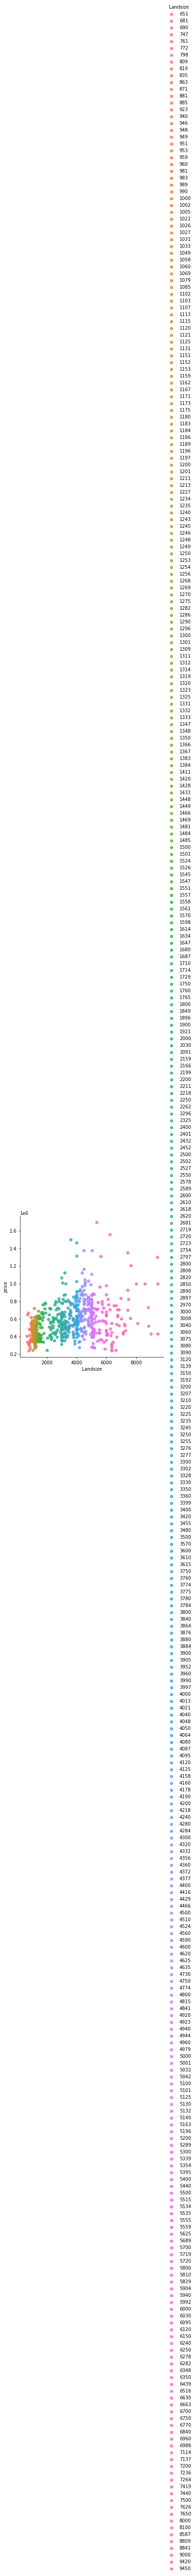

In [34]:
#Scatter plot for .
sns.lmplot(x='Landsize', y='price', data=top1,
           fit_reg=False, # No regression line
           hue='Landsize')   # Color by evolution stage

## 4. Building models

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

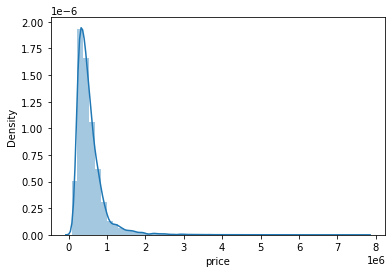

In [35]:
sns.distplot(final['price'])

### 4.1.2 Linear Regression¶

In [36]:
# Creating X and Y (features and labels)
x = final.iloc[:,1:]
y = final.iloc[:,0:1]
X = x.values
Y = y.values

## 4.1 Regression models

### 4.1.1 Linear regression

In [42]:
from sklearn.metrics import r2_score

In [43]:
# from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,Y)

print(f'R² score: {r2_score(Y, lin_reg.predict(X))*100}')

R² score: 70.24047087397621


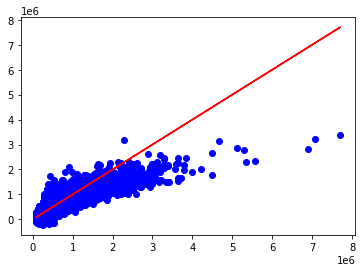

In [39]:
#Linear - Regression Graph
predictArray_lin = lin_reg.predict(X)
plt.scatter(Y,predictArray_lin, color="b")
plt.plot(Y,Y, color="r")

In [40]:
lin_reg.coef_

array([[-3.95158379e+04,  4.31102077e+04,  1.11724955e+02,
         1.21690637e-01,  7.14806472e+03,  5.81648995e+05,
         5.22941336e+04,  2.86587055e+04,  9.69895547e+04,
         7.11782992e+01,  4.05466559e+01,  9.93550659e+03,
         2.12562323e+01, -5.87052816e+02,  6.03747688e+05,
        -2.14683829e+05,  2.07921734e+01, -3.93019530e-01,
         2.24994227e+04,  1.09165743e+03, -3.51875004e+02,
         1.25639161e+04]])

### 4.1.3 Feature engineering

In [44]:
## Find out how many rows is 1% of the whole dataset
len(final)*0.01

214.20000000000002

In [45]:
new_df = final.sort_values(['price'], ascending=False).iloc[212:]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

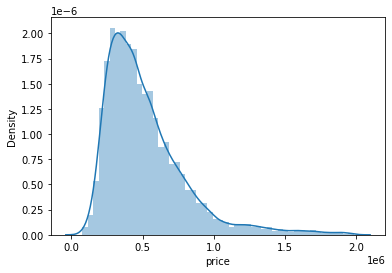

In [46]:
sns.distplot(new_df['price'])

### 4.1.4 Building regression models after feature engineering 

In [47]:
x1 = new_df.iloc[:,1:]
y1 = new_df.iloc[:,0:1]
X1 = x1.values
Y1 = y1.values

In [48]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X1,Y1)
print(f'R² score: {r2_score(Y1, lin_reg.predict(X1))*100}')

R² score: 68.1981101661684


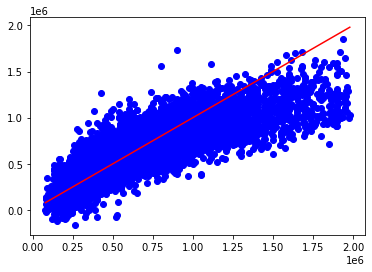

In [49]:
#Linear - Regression Graph
predictArray_lin1 = lin_reg2.predict(X1)
plt.scatter(Y1,predictArray_lin1, color="b")
plt.plot(Y1,Y1, color="r")